# Pilot Analyses -- Psifr Edition

## Setup

In [1]:
#%% Dependencies

from experiments.cat_target_short.helpers import export_to_psifr_long_table, load_data
from psifr import fr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
def export_to_psifr_long_table(data: dict[str, np.ndarray]) -> pd.DataFrame:
    """Convert data in EMBAM format to long table psifr format.

    Args:
        data (dict[str, np.ndarray]): Data in EMBAM format. In EMBAM format, data is stored
        in a dictionary where each key corresponds to a different variable. The values are
        2-D numpy arrays where each row corresponds to a trial. Required fields in the EMBAM
        format are: 'subject', 'listLength', 'pres_itemnos', 'recalls'. Additional fields
        such as 'condition', 'pres_itemids', and 'rec_itemids' can identify details about
        the trial or each presented or recalled item.

    Returns:
        pd.DataFrame: A pandas DataFrame whose rows correspond to a single study or recall
        event. The required fields in each row are 'subject', 'list', 'trial_type', 'position',
        and 'item'. Additional fields can be included to describe events, e.g., 'condition'.
    """
    events = {
        "subject": [],
        "list": [],
        "trial_type": [],
        "position": [],
        "item": [],
        "condition": [],
        "target_success": [],
        "listLength": [],
        "trial_category_cue": [],
        "category": [],
    }

    # first all study events
    for trial_index, trial in enumerate(data["pres_itemids"]):
        for study_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("study")
            events["position"].append(study_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["pres_categoryids"][trial_index, study_index]
            )

    # then all recall events
    for trial_index, trial in enumerate(data["rec_itemids"]):
        for recall_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("recall")
            events["position"].append(recall_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["rec_categoryids"][trial_index, recall_index]
            )

    return pd.DataFrame.from_dict(events)

In [3]:
# %% Load data
embam_data_path = "experiments/cat_target_short/expt_milind_pooled.h5"
embam_data = load_data(embam_data_path)
events = export_to_psifr_long_table(embam_data)
events.head()

,subject,list,trial_type,position,item,condition,target_success,listLength,trial_category_cue,category
0,0,1,study,1,554,2,True,6,9,32
1,0,1,study,2,173,2,True,6,9,10
2,0,1,study,3,5,2,True,6,9,1
3,0,1,study,4,162,2,True,6,9,9
4,0,1,study,5,326,2,True,6,9,19


In [4]:
# %% Merge study and recall events
data = fr.merge_free_recall(
    events,
    list_keys=['condition', 'target_success', 'listLength', 'trial_category_cue', 'category']
)
data.head()


,subject,list,item,input,output,study,recall,repeat,intrusion,condition,target_success,listLength,trial_category_cue,category,prior_list,prior_input
0,0,1,554,1,NaN,True,False,0,False,2,True,6,9,32,NaN,NaN
1,0,1,173,2,5.0,True,True,0,False,2,True,6,9,10,NaN,NaN
2,0,1,5,3,3.0,True,True,0,False,2,True,6,9,1,NaN,NaN
3,0,1,162,4,1.0,True,True,0,False,2,True,6,9,9,NaN,NaN
4,0,1,326,5,2.0,True,True,0,False,2,True,6,9,19,NaN,NaN


## Demo Analyses

Pretty colors.

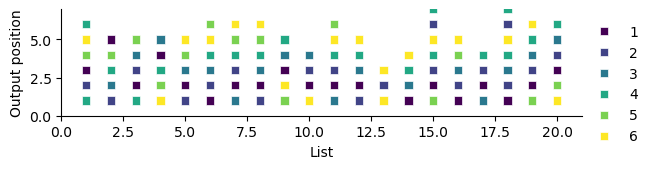

In [5]:
# %% Raster Plot
subj = fr.filter_data(data, 1)
g = fr.plot_raster(subj).add_legend()

Successfully reduced primacy effect in PFR? Yeah. For now.

,subject,output,input,prob,actual,possible,condition
0,0,1,1,0.250,2,8,control
1,0,1,2,0.000,0,8,control
2,0,1,3,0.000,0,8,control
3,0,1,4,0.125,1,8,control
4,0,1,5,0.375,3,8,control
...,...,...,...,...,...,...,...
391,18,6,2,NaN,0,0,failure
392,18,6,3,NaN,0,0,failure
393,18,6,4,NaN,0,0,failure
394,18,6,5,NaN,0,0,failure


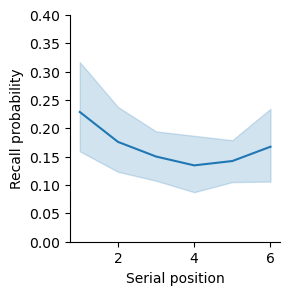

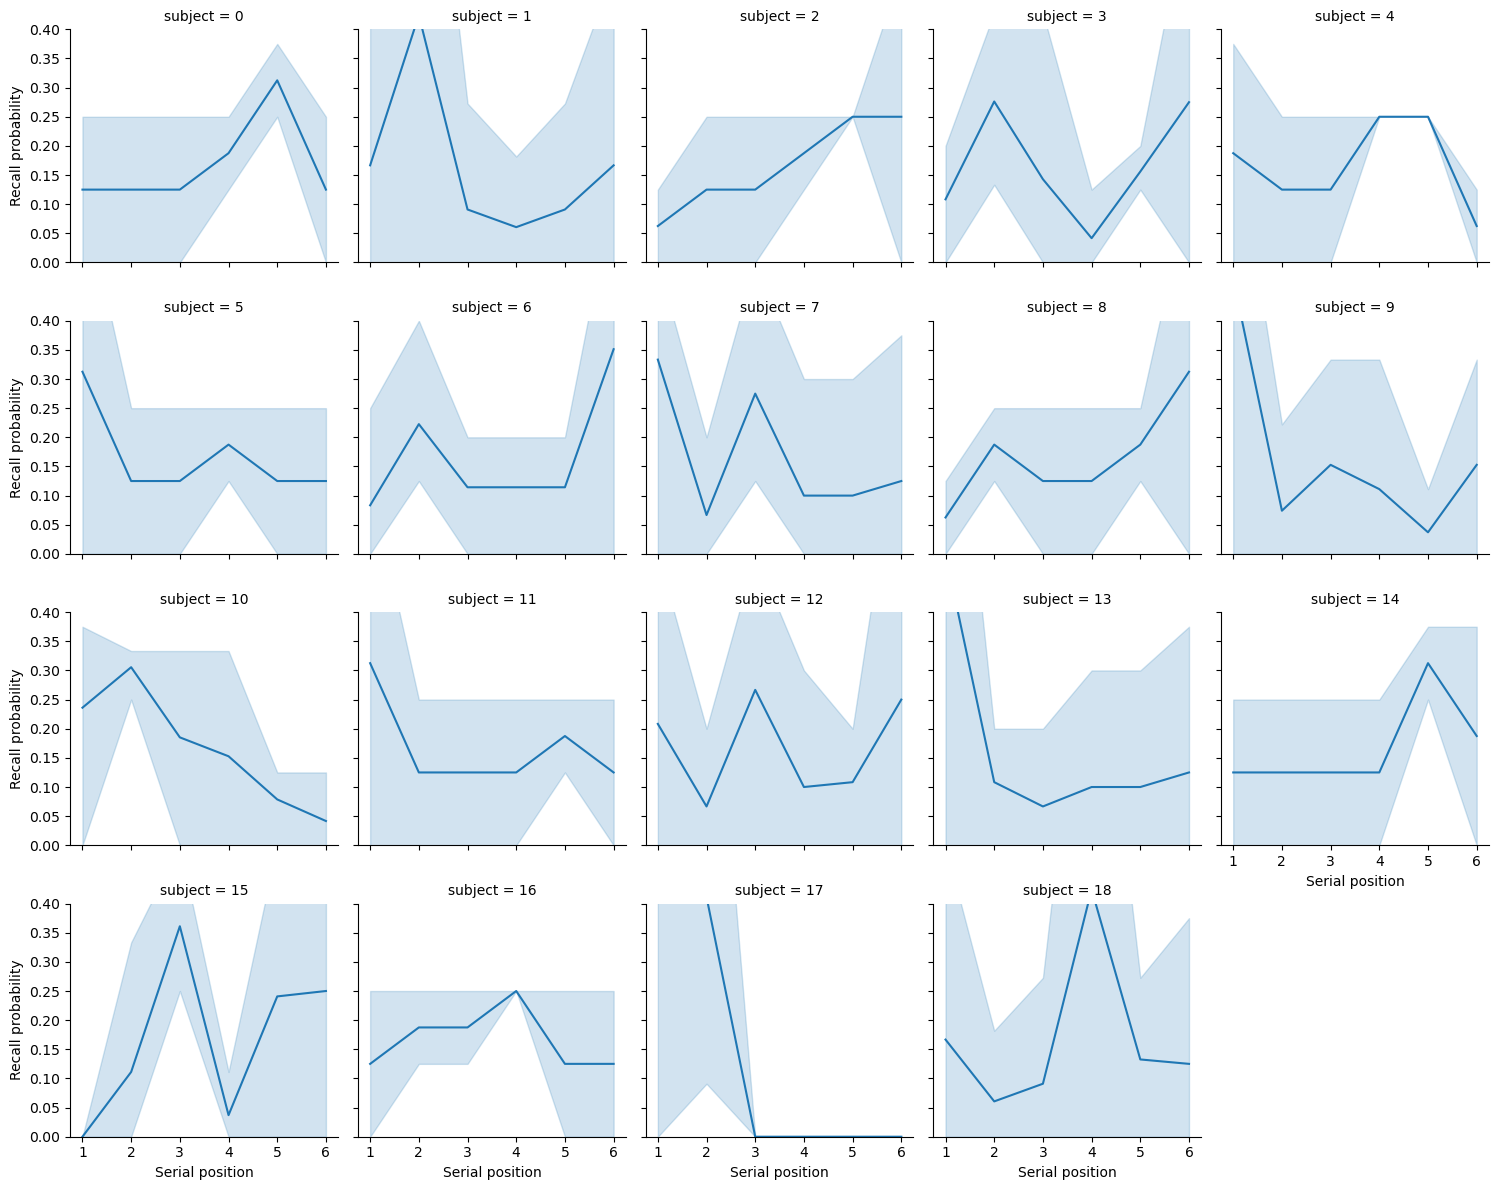

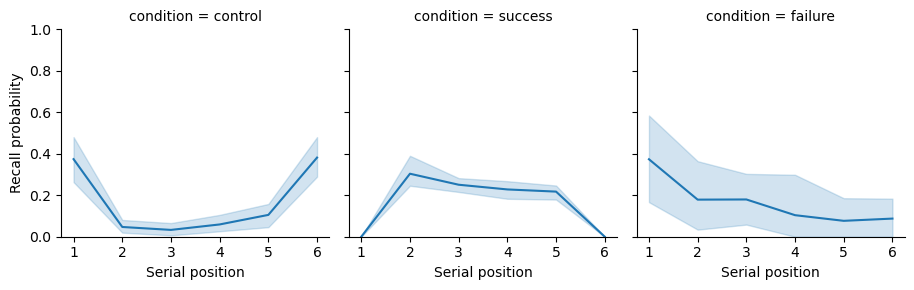

In [6]:
# %% PFR

pnr_control = fr.pnr(data.query('condition == 0'))
pnr_success = fr.pnr(data.query('condition == 2'))
pnr_attempt = fr.pnr(data.query('condition == 1'))
pnr = pd.concat([pnr_control.assign(condition='control'), pnr_success.assign(condition='success'), pnr_attempt.assign(condition='failure')])

pfr = pnr.query('output <= 1')
g = fr.plot_spc(pfr)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='subject', col_wrap=5)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='condition', col_wrap=5)
pnr

Look at what's recalled after the category-cued item.

,subject,output,input,prob,actual,possible,condition
0,0,1,1,0.250,2,8,control
1,0,1,2,0.000,0,8,control
2,0,1,3,0.000,0,8,control
3,0,1,4,0.125,1,8,control
4,0,1,5,0.375,3,8,control
...,...,...,...,...,...,...,...
391,18,6,2,NaN,0,0,failure
392,18,6,3,NaN,0,0,failure
393,18,6,4,NaN,0,0,failure
394,18,6,5,NaN,0,0,failure


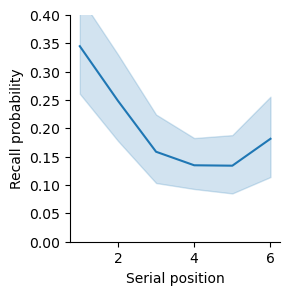

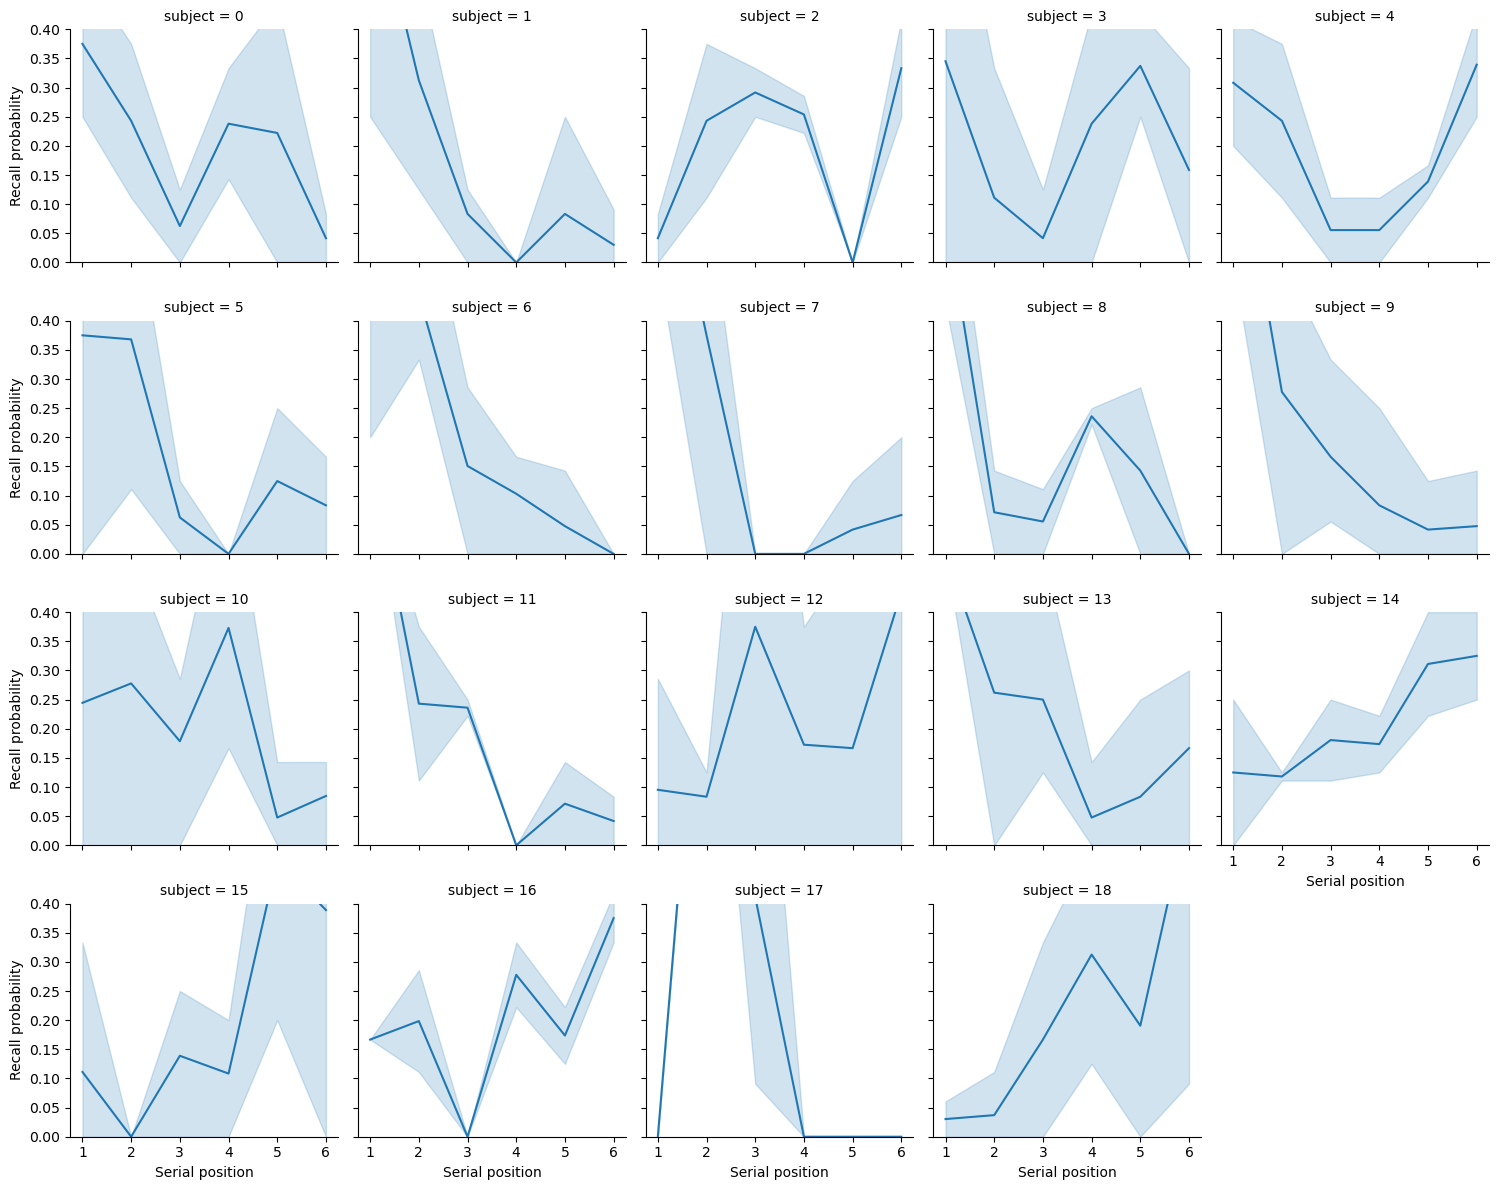

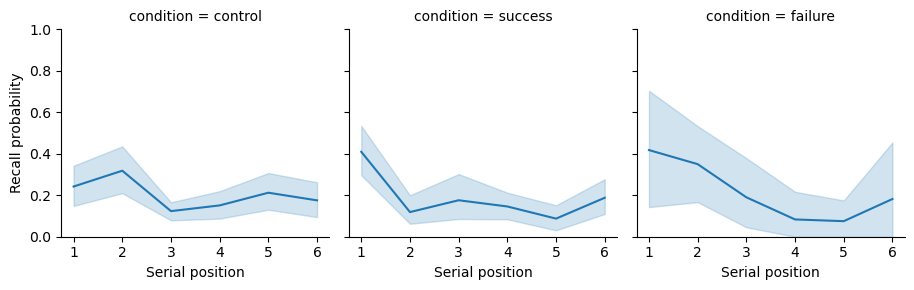

In [7]:
# %% P2R

pnr_control = fr.pnr(data.query('condition == 0'))
pnr_success = fr.pnr(data.query('condition == 2'))
pnr_attempt = fr.pnr(data.query('condition == 1'))
pnr = pd.concat([pnr_control.assign(condition='control'), pnr_success.assign(condition='success'), pnr_attempt.assign(condition='failure')])

pfr = pnr.query('output == 2')
g = fr.plot_spc(pfr)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='subject', col_wrap=5)
plt.ylim([0, .4])
g = fr.plot_spc(pfr, col='condition', col_wrap=5)
pnr

Is lag-contiguity disrupted by our category cueing?

,subject,lag,prob,actual,possible,condition
0,0,-5,1.000000,3,3,control
1,0,-4,0.000000,0,6,control
2,0,-3,0.375000,3,8,control
3,0,-2,0.000000,0,8,control
4,0,-1,0.333333,4,12,control
...,...,...,...,...,...,...
116,18,1,0.000000,0,2,failure
117,18,2,0.500000,1,2,failure
118,18,3,0.000000,0,1,failure
119,18,4,1.000000,1,1,failure


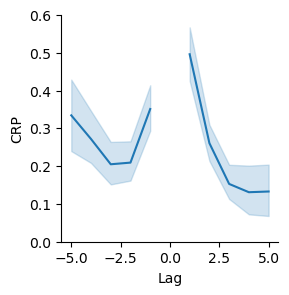

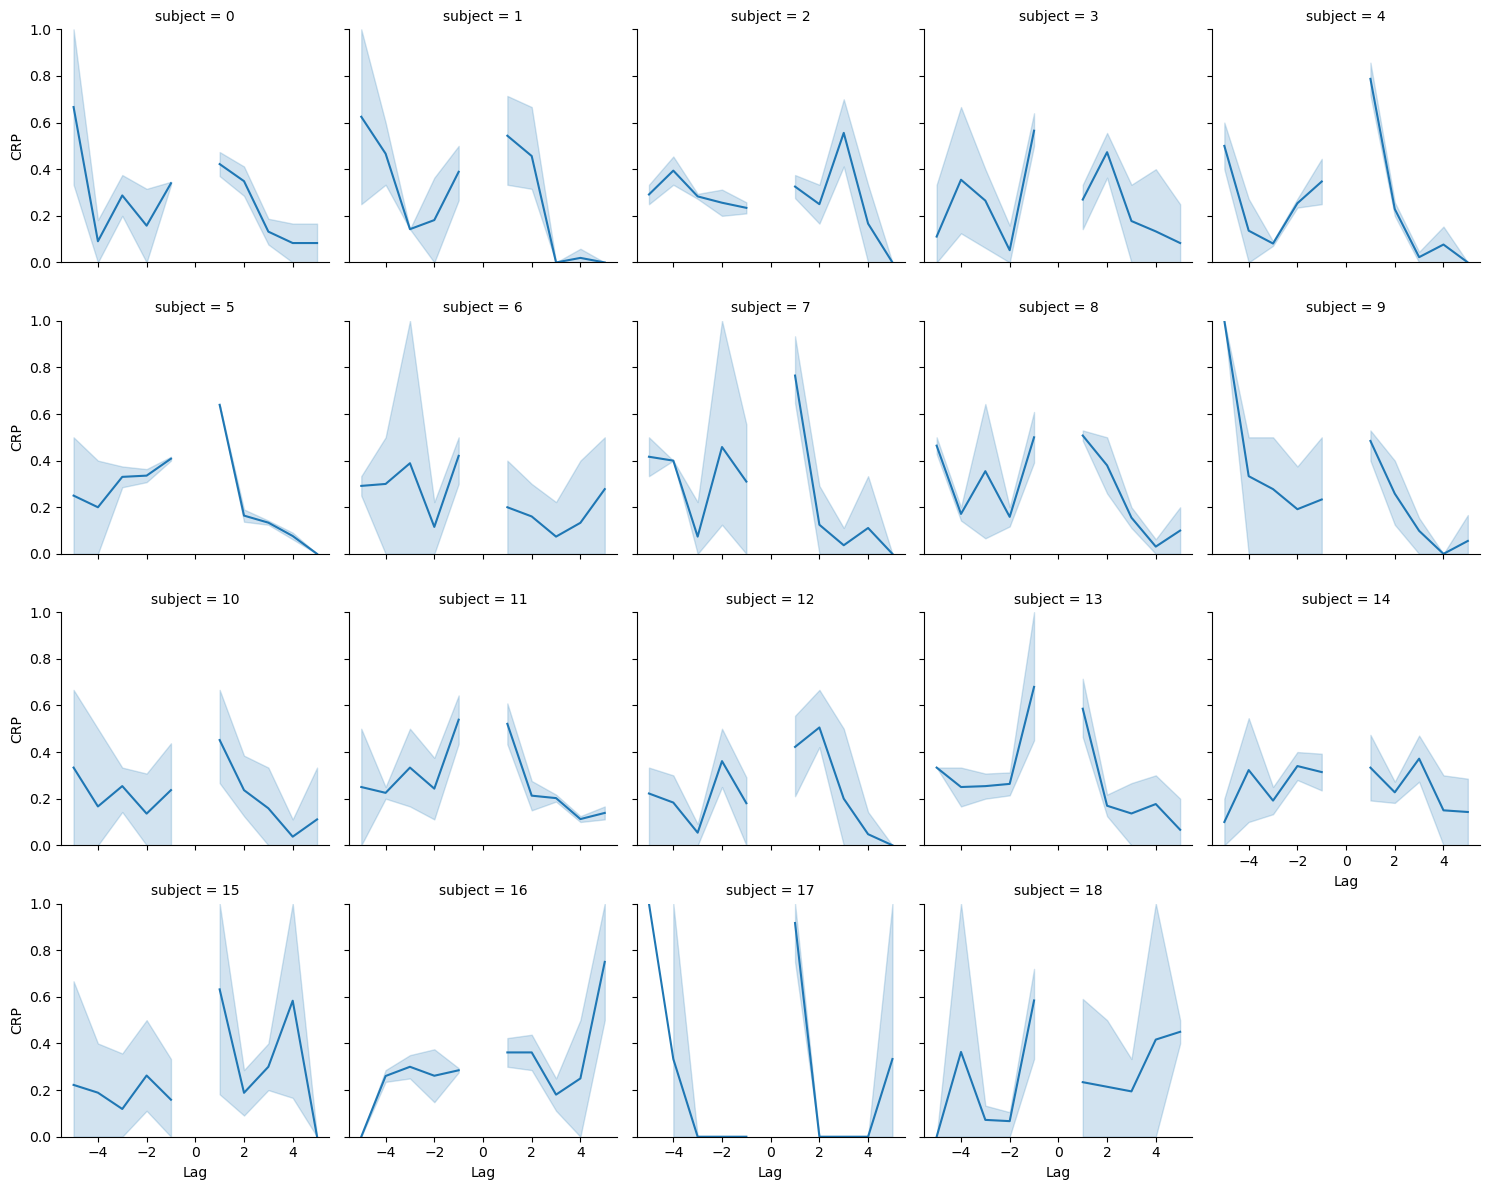

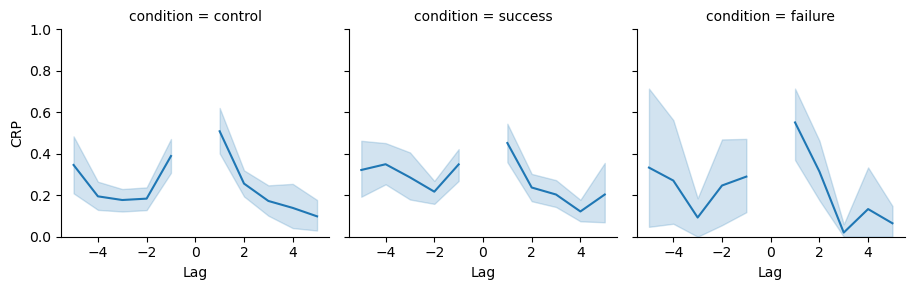

In [8]:
# %% Lag-CRP

crp_control = fr.lag_crp(data.query('condition == 0'))
crp_success = fr.lag_crp(data.query('condition == 2'))
crp_attempt = fr.lag_crp(data.query('condition == 1'))
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

# lag_crp = fr.lag_crp(data)
g = fr.plot_lag_crp(lag_crp)
plt.ylim([0, .6])
g = fr.plot_lag_crp(lag_crp, col='subject', col_wrap=5)
#plt.ylim([0, .6])
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [9]:
# %% Lag-Rank Analysis
ranks_control = fr.lag_rank(data.query('condition == 0'))
ranks_success = fr.lag_rank(data.query('condition == 2'))
ranks_attempt = fr.lag_rank(data.query('condition == 1'))
ranks = pd.concat([ranks_control.assign(condition='control'), ranks_success.assign(condition='success'), ranks_attempt.assign(condition='failure')])

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])
ranks

control
mean    0.649128
sem     0.030577
Name: rank, dtype: float64
success
mean    0.629084
sem     0.028654
Name: rank, dtype: float64
failure
mean    0.719213
sem     0.058255
Name: rank, dtype: float64


,subject,rank,condition
0,0,0.655449,control
1,1,0.669753,control
2,2,0.428571,control
3,3,0.688172,control
4,4,0.716146,control
5,5,0.702957,control
6,6,0.620098,control
7,7,0.889323,control
8,8,0.644531,control
9,9,0.598684,control


## How Often Do Subjects Recall the Category Target?

In [10]:
# %% Focus on targetting trials, then aggregating target_success by subject
success_rates = data.query('condition > 0').pivot_table(
    index='subject', values='target_success', aggfunc='mean')

# mean and sem over subjects
print(success_rates.agg(['mean', 'sem'])['target_success'])
success_rates

mean    0.825433
sem     0.055258
Name: target_success, dtype: float64


,target_success
subject,
0,1.000000
1,0.920000
2,1.000000
3,0.604938
4,1.000000
5,1.000000
6,0.418919
7,0.825581
8,1.000000


## Focusing on Transitions From Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-5,1.00,2,2,control
1,0,-4,0.00,0,1,control
2,0,-3,0.75,3,4,control
3,0,-2,0.00,0,1,control
4,0,-1,0.20,1,5,control
...,...,...,...,...,...,...
116,18,1,NaN,0,0,failure
117,18,2,1.00,1,1,failure
118,18,3,NaN,0,0,failure
119,18,4,NaN,0,0,failure


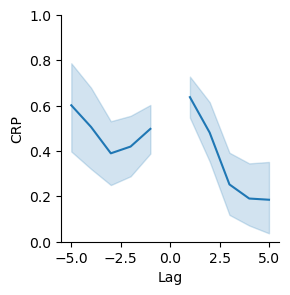

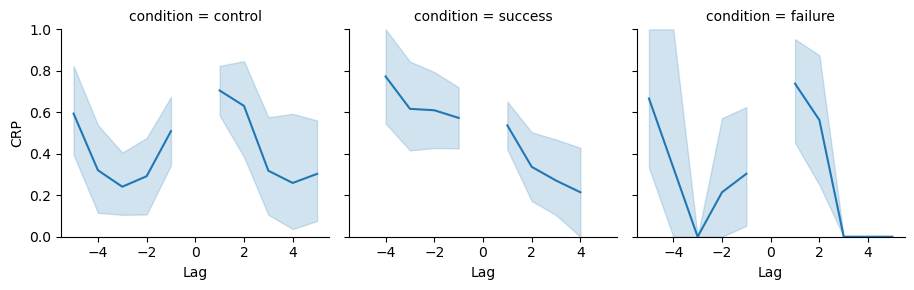

In [11]:
# %% First Transition Lag-CRP
crp_control = fr.lag_crp(data.query('condition == 0'), item_query='output < 3 or not recall')
crp_success = fr.lag_crp(data.query('condition == 2'), item_query='output < 3 or not recall')
crp_attempt = fr.lag_crp(data.query('condition == 1'), item_query='output < 3 or not recall')
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

,subject,lag,prob,actual,possible,condition
0,0,-5,NaN,0,0,control
1,0,-4,NaN,0,0,control
2,0,-3,NaN,0,0,control
3,0,-2,NaN,0,0,control
4,0,-1,1.0,1,1,control
...,...,...,...,...,...,...
116,18,1,NaN,0,0,failure
117,18,2,1.0,1,1,failure
118,18,3,NaN,0,0,failure
119,18,4,NaN,0,0,failure


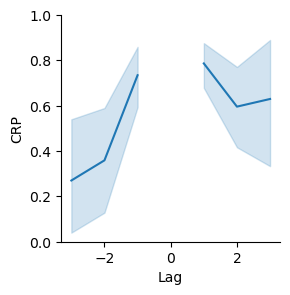

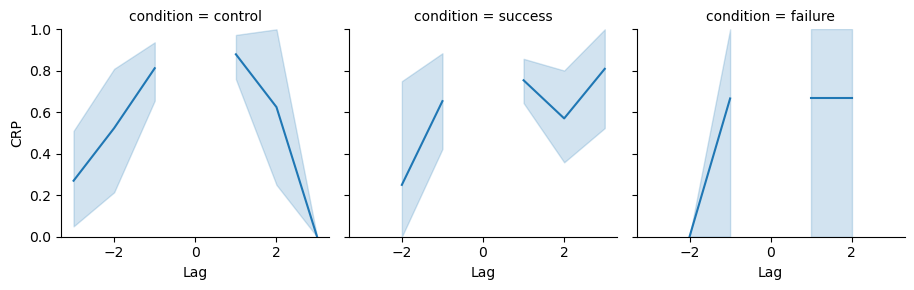

In [12]:
#! code-summary: added query to exclude transitiosn to first item in the list in our condition==2

crp_control = fr.lag_crp(data.query('condition == 0'),  item_query='(output < 3 or not recall) and input > 2')
crp_success = fr.lag_crp(data.query('condition == 2'),  item_query='(output < 3 or not recall) and input > 2')
crp_attempt = fr.lag_crp(data.query('condition == 1'),  item_query='(output < 3 or not recall) and input > 2')
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [13]:
# %% First Transition Lag-Rank

ranks_control = fr.lag_rank(data.query('condition == 0'), item_query='output < 3 or not recall')
ranks_success = fr.lag_rank(data.query('condition == 2'), item_query='output < 3 or not recall')
ranks_attempt = fr.lag_rank(data.query('condition == 1'), item_query='output < 3 or not recall')

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.574890
sem     0.070629
Name: rank, dtype: float64
success
mean    0.475631
sem     0.047335
Name: rank, dtype: float64
failure
mean    0.714286
sem     0.098781
Name: rank, dtype: float64


/Users/jordangunn/miniconda3/envs/jaxcmr/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,subject,rank
0,0,0.613636
1,1,0.535714
2,2,0.333333
3,3,0.500000
4,4,0.833333
5,5,0.375000
6,6,0.550000
7,7,0.000000
8,8,0.250000
9,9,0.357143


## Modification: Ignore Transitions to First Item from Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-5,NaN,0,0,control
1,0,-4,NaN,0,0,control
2,0,-3,1.000000,2,2,control
3,0,-2,NaN,0,0,control
4,0,-1,0.333333,1,3,control
...,...,...,...,...,...,...
116,18,1,NaN,0,0,failure
117,18,2,1.000000,1,1,failure
118,18,3,NaN,0,0,failure
119,18,4,NaN,0,0,failure


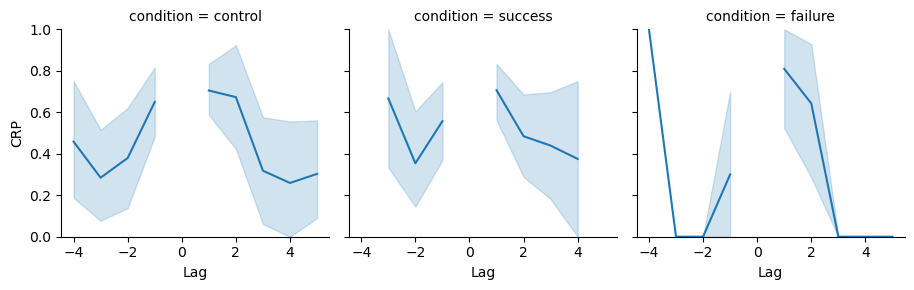

In [14]:
crp_control = fr.lag_crp(
    data.query('condition == 0'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
crp_success = fr.lag_crp(
    data.query('condition == 2'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
crp_attempt = fr.lag_crp(
    data.query('condition == 1'),
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

# g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [15]:
ranks_control = fr.lag_rank(
    data.query('condition == 0'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
ranks_success = fr.lag_rank(
    data.query('condition == 2'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
ranks_attempt = fr.lag_rank(
    data.query('condition == 1'),
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
ranks = pd.concat([ranks_control.assign(condition='control'), ranks_success.assign(condition='success'), ranks_attempt.assign(condition='failure')])

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.608887
sem     0.067851
Name: rank, dtype: float64
success
mean    0.521652
sem     0.073006
Name: rank, dtype: float64
failure
mean    0.754167
sem     0.112911
Name: rank, dtype: float64


/Users/jordangunn/miniconda3/envs/jaxcmr/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
/Users/jordangunn/miniconda3/envs/jaxcmr/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
/Users/jordangunn/miniconda3/envs/jaxcmr/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]
/Users/jordangunn/miniconda3/envs/jaxcmr/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,subject,rank
0,0,0.583333
1,1,0.666667
2,2,0.400000
3,3,0.000000
4,4,0.500000
5,5,0.500000
6,6,0.375000
7,7,NaN
8,8,NaN
9,9,1.000000


## Focusing on Transitions from Mid-Sequence Items

,subject,lag,prob,actual,possible,condition
0,0,-5,NaN,0,0,control
1,0,-4,0.0,0,3,control
2,0,-3,0.5,3,6,control
3,0,-2,0.0,0,6,control
4,0,-1,0.4,4,10,control
...,...,...,...,...,...,...
116,18,1,0.0,0,2,failure
117,18,2,1.0,1,1,failure
118,18,3,0.0,0,1,failure
119,18,4,NaN,0,0,failure


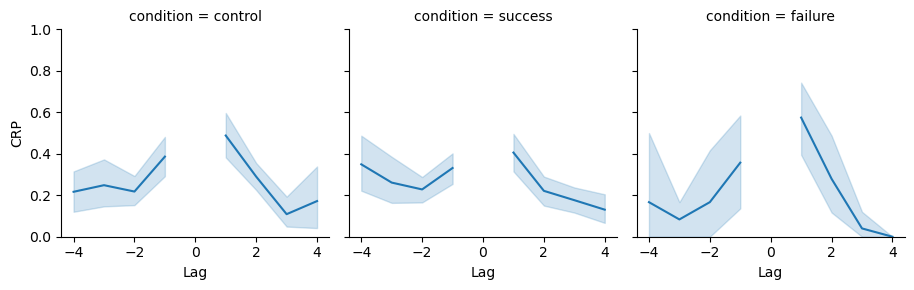

In [16]:
# %% From Mid-List Transition Lag-CRP
crp_control = fr.lag_crp(
    data.query('condition == 0'), 
    test_key='input', test=lambda x, y: 2 <= x <= 5
)
crp_success = fr.lag_crp(
    data.query('condition == 2'), 
    test_key='input', test=lambda x, y: 2 <= x <= 5
)
crp_attempt = fr.lag_crp(
    data.query('condition == 1'),
    test_key='input', test=lambda x, y: 2 <= x <= 5
)
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])
# g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [17]:
# %% From-Mid-List Transition Lag-Rank

ranks_control = fr.lag_rank(data.query('condition == 0'), 
    test_key='input', test=lambda x, y: 2 <= x <= 5
)
ranks_success = fr.lag_rank(data.query('condition == 2'), 
    test_key='input', test=lambda x, y: 2 <= x <= 5
)
ranks_attempt = fr.lag_rank(data.query('condition == 1'), 
    test_key='input', test=lambda x, y: 2 <= x <= 5
)

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.642316
sem     0.038637
Name: rank, dtype: float64
success
mean    0.604393
sem     0.030870
Name: rank, dtype: float64
failure
mean    0.733873
sem     0.047610
Name: rank, dtype: float64


,subject,rank
0,0,0.595052
1,1,0.651042
2,2,0.413889
3,3,0.581140
4,4,0.803922
5,5,0.664062
6,6,0.479167
7,7,0.724138
8,8,0.621212
9,9,0.480392


In [18]:
# %% Comparison: From-Early-Or-Late-List Transition Lag-Rank

ranks_control = fr.lag_rank(data.query('condition == 0'), 
    test_key='input', test=lambda x, y: (x < 2) or (x > 5)
)
ranks_success = fr.lag_rank(data.query('condition == 2'), 
    test_key='input', test=lambda x, y: (x < 2) or (x > 5)
)
ranks_attempt = fr.lag_rank(data.query('condition == 1'), 
    test_key='input', test=lambda x, y: (x < 2) or (x > 5)
)

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("success")
print(ranks_success.agg(['mean', 'sem'])['rank'])
print("failure")
print(ranks_attempt.agg(['mean', 'sem'])['rank'])

ranks_success

control
mean    0.665260
sem     0.035299
Name: rank, dtype: float64
success
mean    0.682561
sem     0.041978
Name: rank, dtype: float64
failure
mean    0.723725
sem     0.090241
Name: rank, dtype: float64


/Users/jordangunn/miniconda3/envs/jaxcmr/lib/python3.12/site-packages/psifr/measures.py:236: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


,subject,rank
0,0,0.766667
1,1,0.818182
2,2,0.600000
3,3,0.595238
4,4,0.797619
5,5,0.861111
6,6,0.166667
7,7,0.851852
8,8,0.642857
9,9,0.904762
